In [75]:
import torch
from PIL import Image


In [15]:
import pandas as pd
import os


train_labels = pd.read_csv("data/train_labels.csv")
baseline_helmets = pd.read_csv("data/train_baseline_helmets.csv")

In [3]:
baseline_helmets.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [68]:
train_labels["frame"] =train_labels["step"]/10*59.95+5*59.95  
train_labels["frame"] = train_labels["frame"].astype(int) 
train_labels[train_labels['contact']==1].head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame
809,58168_003392_3_41944_42565,58168_003392,2020-09-11T03:01:48.400Z,3,41944,42565,1,317
1062,58168_003392_4_41944_42565,58168_003392,2020-09-11T03:01:48.500Z,4,41944,42565,1,323
1163,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,4,37084,38567,1,323
1289,58168_003392_5_43854_46445,58168_003392,2020-09-11T03:01:48.600Z,5,43854,46445,1,329
1315,58168_003392_5_41944_42565,58168_003392,2020-09-11T03:01:48.600Z,5,41944,42565,1,329


player1_id 38577 player2_id 41366
frame  425
58245_002594_Sideline.mp4_0425.jpg


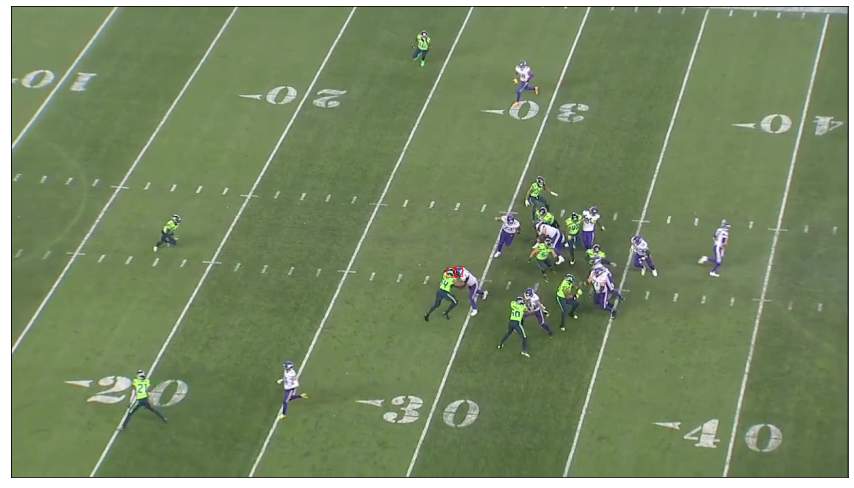

In [84]:
import random
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from torchvision.io import read_image
view = "Sideline"
idx = random.randint(0, train_labels.shape[0])
label_record = train_labels.iloc[idx]

positive_labels = train_labels[train_labels['contact']==1]

idx = random.randint(0, positive_labels.shape[0])
label_record = positive_labels.iloc[idx]

player1_id = int(label_record["nfl_player_id_1"])
player2_id = int(label_record["nfl_player_id_2"])
print("player1_id", player1_id, "player2_id", player2_id)
game_play = label_record['game_play']
frame = int(label_record['frame'])
print("frame ", frame)

player1_record = baseline_helmets[(baseline_helmets['game_play']==game_play)&
(baseline_helmets['nfl_player_id']==player1_id)&(baseline_helmets['frame']==frame)].iloc[0]
# print(player1_record)
ymin1 = player1_record["top"]
xmin1 = player1_record["left"]
height1 = player1_record["height"]
width1 = player1_record["width"]

xmax1 = xmin1+width1
ymax1 = ymin1+height1

player2_record = baseline_helmets[(baseline_helmets['game_play']==game_play)&
(baseline_helmets['nfl_player_id']==player2_id)&(baseline_helmets['frame']==frame)].iloc[0]
# print(player2_record)
ymin2 = player2_record["top"]
xmin2 = player2_record["left"]
height2 = player2_record["height"]
width2 = player2_record["width"]

xmax2 = xmin2+width2
ymax2 = ymin2+height2

file_name = game_play+"_" + view +".mp4_{:04d}.jpg".format(frame)
print(file_name)
# file_name ="58579_003527_Sideline.mp4_0775.jpg"
# file_name ="58168_003392_Endzone.mp4_0329.jpg"
image = read_image("data/extracted-train-frames/content/work/frames/train/"+file_name)
boxes = torch.tensor([[xmin1,ymin1,xmax1,ymax1],[xmin2,ymin2,xmax2,ymax2]])



def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

drawn_boxes = draw_bounding_boxes(image, boxes, colors="red")
show(drawn_boxes)


In [85]:
import torchvision

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/azureuser/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


In [111]:
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
class NFLDataset(torch.utils.data.Dataset):
    def __init__(self,labels, helmets,transforms):
        self.labels = labels
        self.helmets = helmets
        self.ft_extractor = torchvision.models.resnet18(pretrained=True)
        for param in self.ft_extractor.parameters():
            param.requires_grad = False
        num_ftrs = self.ft_extractor.fc.in_features
        model_conv.fc = Identity()

        self.transforms = transforms

    def __getitem__(self, idx):
        view = "Sideline"
        label_record = train_labels.iloc[idx]
        label_record = train_labels.iloc[idx]
        label = label_record['contact']
        game_play = label_record['game_play']
        frame = int(label_record['frame'])
        boxes =[]
        for player in [1,2]:

            player1_id = int(label_record["nfl_player_id_1"])
            player2_id = int(label_record["nfl_player_id_2"])
            print("player1_id", player1_id, "player2_id", player2_id)

            print("frame ", frame)

            player1_record = baseline_helmets[(baseline_helmets['game_play']==game_play)&
            (baseline_helmets['nfl_player_id']==player1_id)&(baseline_helmets['frame']==frame)].iloc[0]
            ymin1 = player1_record["top"]
            xmin1 = player1_record["left"]
            height1 = player1_record["height"]
            width1 = player1_record["width"]

            xmax1 = xmin1+width1
            ymax1 = ymin1+height1

            boxes.append([xmin1,ymin1,xmax1,ymax1])

        file_name = game_play+"_" + view +".mp4_{:04d}.jpg".format(frame)
        print(file_name)
        image = read_image("data/extracted-train-frames/content/work/frames/train/"+file_name)
        image = image.float().unsqueeze(0)
        image_ft = self.ft_extractor(image)
        boxes = torch.tensor(boxes)
        return image_ft, label

    def __len__(self):
        return len(self.imgs)


In [113]:
ds = NFLDataset(train_labels,baseline_helmets, None)

ds.__getitem__(1)

player1_id 38590 player2_id 41257
frame  299
player1_id 38590 player2_id 41257
frame  299
58168_003392_Sideline.mp4_0299.jpg


(tensor([[-5.7284e-01, -4.6466e-01, -5.3065e-01, -1.3811e+00, -5.4494e-01,
          -9.6706e-02, -4.1123e-01,  3.5763e-01,  2.4232e-01, -7.5180e-01,
          -9.0438e-01, -7.9103e-01, -2.9700e-01, -8.5393e-01, -9.6093e-01,
          -5.4207e-01, -8.2105e-01, -2.0147e-01, -3.8194e-01, -4.8723e-01,
          -1.4516e+00, -6.7933e-01, -1.3008e+00,  1.0396e-01, -8.8386e-01,
          -1.0882e+00, -7.8278e-01, -1.0865e+00, -8.4456e-01, -3.9841e-01,
          -7.9390e-01, -7.9181e-01, -4.8350e-01, -5.0472e-01, -3.9251e-01,
          -5.2660e-01,  4.8554e-01, -7.1068e-01, -4.8734e-01,  5.5475e-02,
          -6.0868e-01, -7.7577e-01, -1.0333e+00, -3.9482e-01, -5.8653e-01,
          -4.2167e-01, -6.6129e-01, -4.8547e-01, -1.1067e+00, -1.0250e+00,
          -3.8303e-01,  3.6026e-01, -3.5081e-01, -5.8909e-01, -1.9980e-01,
          -9.9409e-01, -4.0283e-01, -1.4131e+00, -4.0477e-01, -3.6882e-01,
           6.6896e-01,  1.1161e-01, -1.1967e-01,  1.6212e-01, -6.1028e-01,
          -1.0488e-01, -3